### Online reviews study

In [249]:
%matplotlib inline
% load_ext autoreload
% autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from scipy.sparse import hstack
from random import seed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
seed(1)

### Imputation

A missing title, a missing review, or both of them missing may be useful information (for instance we could think that people that would not recommend the product would tend to argue and defend their choice by leaving a review). To fill missing values, I chose *'missing_title'*, *'missing_review'* and *'missing_both'*.

In [191]:
dico = {'Title':'missing_title',
        'Review':'missing_review'}
df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')
df_train = df_train.fillna(dico)
df_test = df_test.fillna(dico)
df_train['Concat'] = df_train['Title'] + (' ') + df_train['Review']
df_test['Concat'] = df_test['Title'] + (' ') + df_test['Review']
df_train['Concat'] = df_train['Concat'].replace('missing_title missing_review',
                                                'missing_both')
df_test['Concat'] = df_test['Concat'].replace('missing_title missing_review',
                                              'missing_both')

Slightly modified version of plot_important_features in class notebooks.

In [244]:
def plot_important_features(coef, feature_names, 
                            min_size=1, top_n=20, ax=None, rotation=60):
    
    if min_size > 1:
        mask = np.array([len(i.split(" ")) >= min_size for i in list(feature_names)])
        feature_names = feature_names[mask]
        coef = coef[mask]
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation,
                       ha="right", fontsize=14)
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

# Task 1: Title and Body

## 1)

In [224]:
df = df_train[['Title', 'Recommended']]
txt = df['Title'].ravel()
y = df_train['Recommended'].ravel()
txt_train, txt_val, y_train, y_val = train_test_split(txt, y, stratify=y)

In [225]:
vect = CountVectorizer()
X_train = vect.fit_transform(txt_train)
X_val = vect.transform(txt_val)

In [226]:
clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
print(roc_auc_score(y_val,clf.predict(X_val)))

0.731371301552


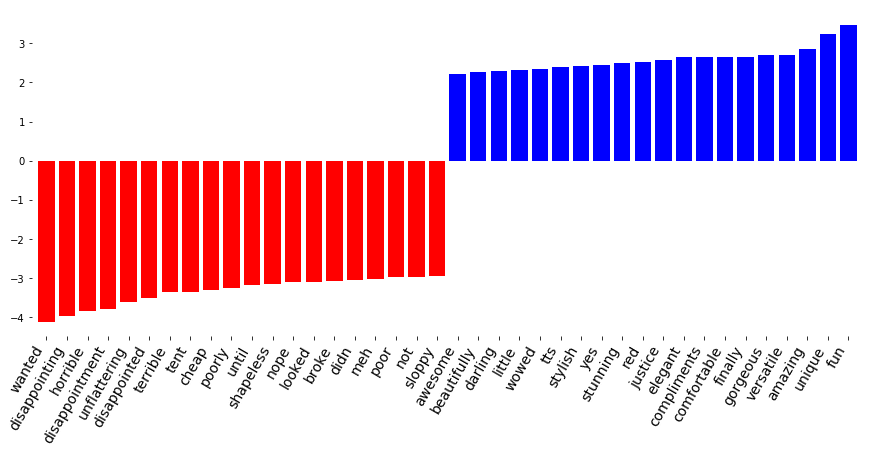

In [227]:
plt.figure(figsize=(15, 6))
plot_important_features(clf.coef_.ravel(), np.array(vect.get_feature_names()))
plt.show()

There is a clear dicotomia between the 10 most positive features and the 10 most negative ones. The title seems to be a good indicator of whether the review author would recommend the product or not. Stemming the title (**'disappointed'**, **'disappointing'**, **'disappointment'**) would be a good idea.

## 2)

In [228]:
df = df_train[['Review', 'Recommended']]
txt = df['Review'].ravel()
y = df_train['Recommended'].ravel()
txt_train, txt_val, y_train, y_val = train_test_split(txt, y, stratify=y)

In [229]:
%%time
vect = CountVectorizer()
X_train = vect.fit_transform(txt_train)
X_val = vect.transform(txt_val)
clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
print(roc_auc_score(y_val,clf.predict(X_val)))

0.744493017239
CPU times: user 18 s, sys: 325 ms, total: 18.4 s
Wall time: 10.1 s


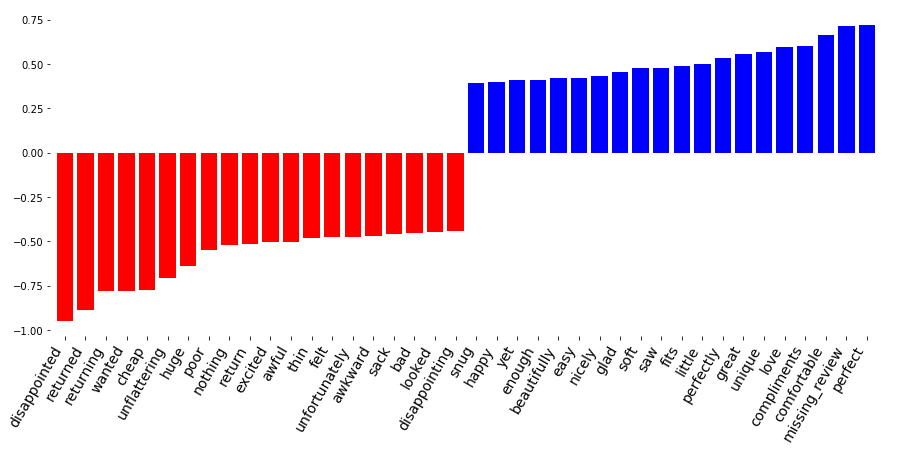

In [230]:
plt.figure(figsize=(15, 6))
plot_important_features(clf.coef_.ravel(), np.array(vect.get_feature_names()))
plt.show()

The **'missing_review'** is one of the most positive feature, that confirms our idea that people would argue when they are not satisfied and explain why they would not recommend a product by leaving a review.

## 3)

In [231]:
df = df_train[['Concat', 'Recommended']]
txt = df['Concat'].ravel()
y = df['Recommended'].ravel()
txt_train, txt_val, y_train, y_val = train_test_split(txt, y, stratify=y)

In [232]:
%%time
vect = CountVectorizer()
X_train = vect.fit_transform(txt_train)
X_val = vect.transform(txt_val)
clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
print(roc_auc_score(y_val,clf.predict(X_val)))

0.77365058092
CPU times: user 18.7 s, sys: 336 ms, total: 19 s
Wall time: 10.7 s


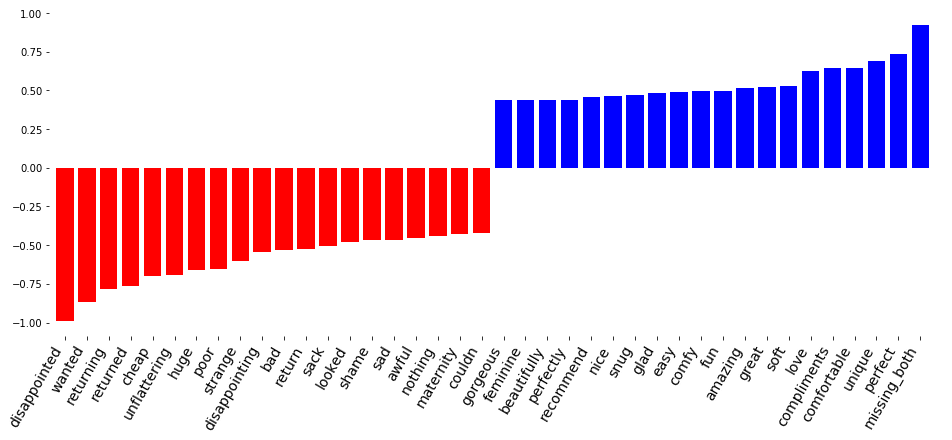

In [233]:
plt.figure(figsize=(16, 6))
plot_important_features(clf.coef_.ravel(), np.array(vect.get_feature_names()))
plt.show()

When using both title and review, **'missing_both'** is the most positive feature.

## 4)

In [237]:
df = df_train[['Title', 'Review', 'Recommended']]
txt = df[['Title','Review']]
y = df['Recommended'].ravel()
txt_train, txt_val, y_train, y_val = train_test_split(txt, y, stratify=y)

txt_train_title = txt_train['Title'].ravel()
txt_train_review = txt_train['Review'].ravel()
txt_val_title = txt_val['Title'].ravel()
txt_val_review = txt_val['Review'].ravel()

vect_title = CountVectorizer()
X_train_title = vect_title.fit_transform(txt_train_title)
X_val_title = vect_title.transform(txt_val_title)

vect_review = CountVectorizer()
X_train_review = vect_review.fit_transform(txt_train_review)
X_val_review = vect_review.transform(txt_val_review)

In [238]:
X_train = hstack((X_train_title, X_train_review))
X_val = hstack((X_val_title, X_val_review))
clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
print(roc_auc_score(y_val,clf.predict(X_val)))

0.801594687763


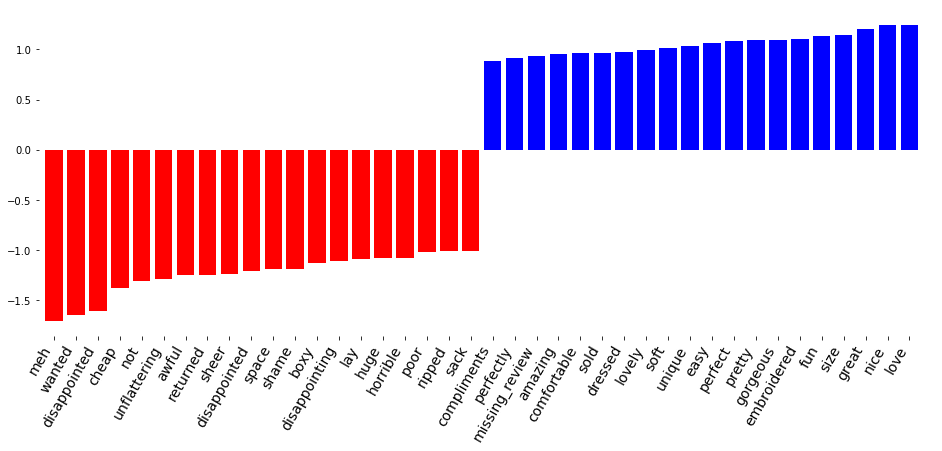

In [239]:
plt.figure(figsize=(16, 6))
plot_important_features(clf.coef_.ravel(), np.array(vect_title.get_feature_names() + 
                                                    vect_review.get_feature_names()))
plt.show()

When vectorizing title and review individually and concatenating the vector representations, **'missing_review'** is the 10 most positive features. What's more, the features seem to be a mix from features in the first and second model, which makes sense.

### Test set

The best model for task 1 is the one obtained at 4), when vectorizing title and review individually and concatenating the vector representations. 

In [206]:
%%time
txt_train_title = df_train['Title'].ravel()
txt_train_review = df_train['Review'].ravel()
y_train = df_train['Recommended'].ravel()
txt_test_title = df_test['Title'].ravel()
txt_test_review = df_test['Review'].ravel()
y_test = df_test['Recommended'].ravel()

vect_title = CountVectorizer()
X_train_title = vect_title.fit_transform(txt_train_title)
X_test_title = vect_title.transform(txt_test_title)
vect_review = CountVectorizer()
X_train_review = vect_review.fit_transform(txt_train_review)
X_test_review = vect_review.transform(txt_test_review)

X_train = hstack((X_train_title, X_train_review))
X_test = hstack((X_test_title, X_test_review))
clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
print(roc_auc_score(y_test,clf.predict(X_test)))

0.811238309931
CPU times: user 27.2 s, sys: 729 ms, total: 27.9 s
Wall time: 17.6 s


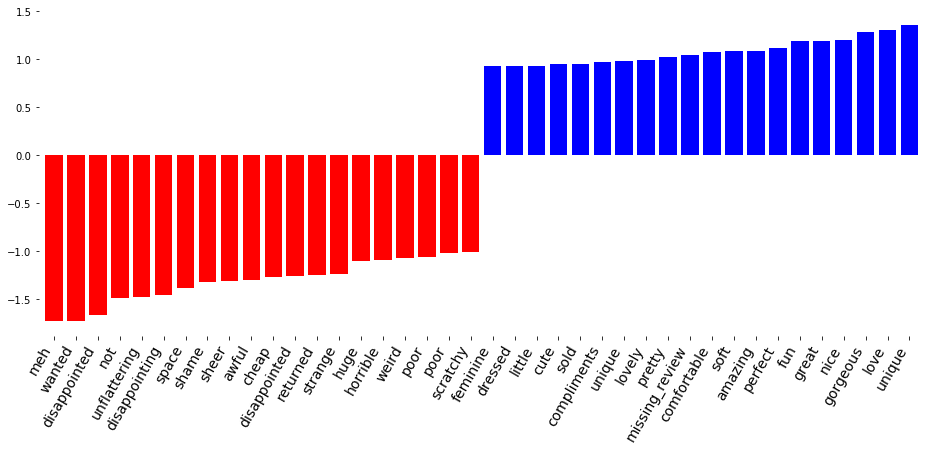

In [207]:
plt.figure(figsize=(16, 6))
plot_important_features(clf.coef_.ravel(), np.array(vect_title.get_feature_names() + 
                                                    vect_review.get_feature_names()))
plt.show()

# Task 2: Feature Tuning

In [208]:
df = df_train[['Concat', 'Recommended']]
txt = df['Concat'].ravel()
y = df['Recommended'].ravel()
txt_train, txt_val, y_train, y_val = train_test_split(txt, y, stratify=y)

## 1)

In [209]:
%%time
tfidf_vect = TfidfVectorizer()
X_train = tfidf_vect.fit_transform(txt_train)
X_val = tfidf_vect.transform(txt_val)
clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
print(roc_auc_score(y_val, clf.predict(X_val)))

0.785864234057
CPU times: user 15.9 s, sys: 447 ms, total: 16.4 s
Wall time: 11.3 s


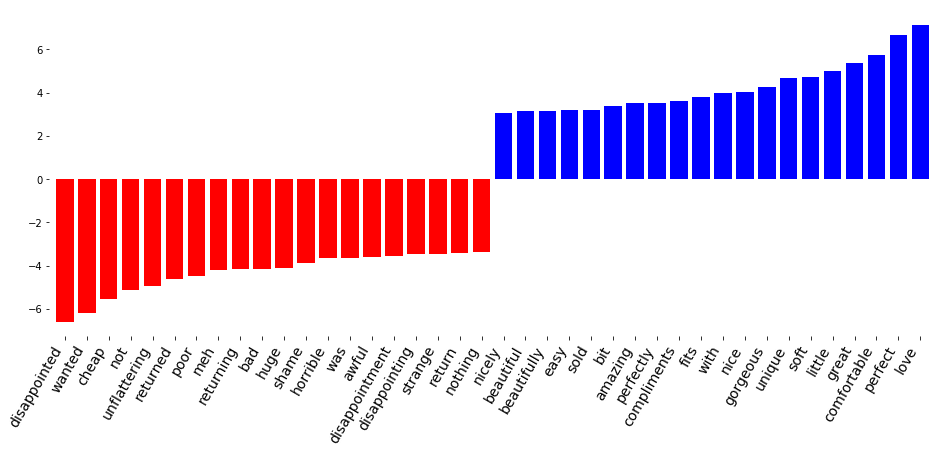

In [210]:
plt.figure(figsize=(16, 6))
plot_important_features(clf.coef_.ravel(), np.array(tfidf_vect.get_feature_names()))
plt.show()

Using TfidfVectorizer instead of CountVectorizer slightly increases the score, compared to 1.3). There are only a few differences between the important coefficients.

## 2)

In [211]:
pipe = make_pipeline(CountVectorizer(), Normalizer())
X_train = pipe.fit_transform(txt_train)
X_val = pipe.transform(txt_val)
clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
print(roc_auc_score(y_val, clf.predict(X_val)))

0.800453960664


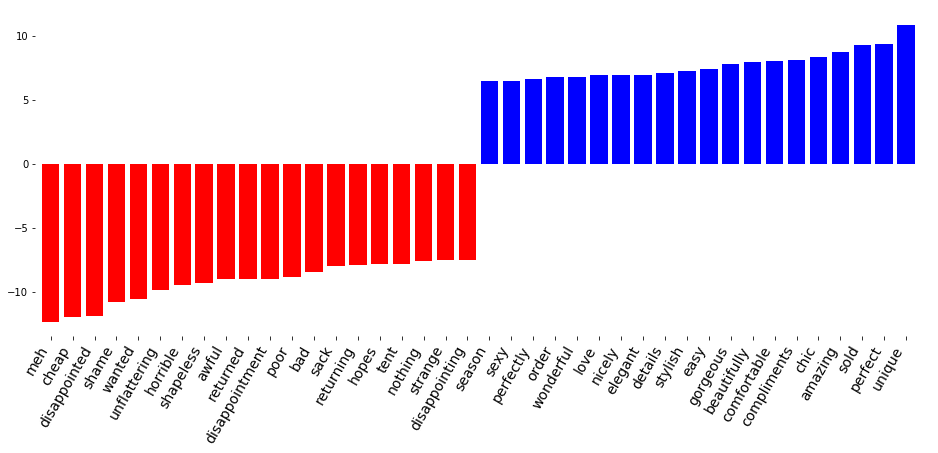

In [212]:
plt.figure(figsize=(16, 6))
plot_important_features(clf.coef_.ravel(),
                        np.array(pipe.steps[0][1].get_feature_names()))
plt.show()

Using a Normalizer with CountVectorizer increases the AUC score and seems to bring to the surface only meaningful features (it got rid of **'was'** for instance).

## 3)

In [213]:
vect = CountVectorizer(stop_words='english')
X_train = vect.fit_transform(txt_train)
X_val = vect.transform(txt_val)
clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
print(roc_auc_score(y_val, clf.predict(X_val)))

0.753582469168


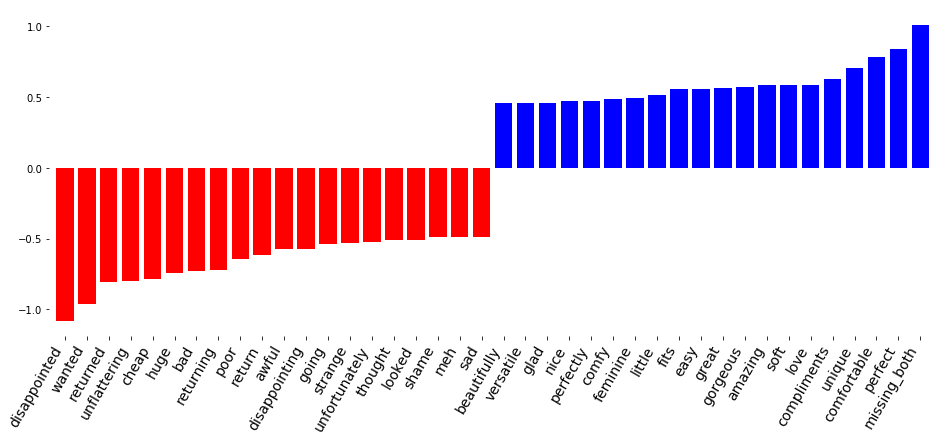

In [214]:
plt.figure(figsize=(16, 6))
plot_important_features(clf.coef_.ravel(), np.array(vect.get_feature_names()))
plt.show()

Using standard English stop-words does not seem to help. We get a lower AUC score (maybe because of **'was'** removal ?). To make it efficient, we should use stop-words specific to that kind of review.

## 4)

In [215]:
%%time
x = []
vect_size = []
score = []

for min_df in np.arange(1,20,1):
    vect = CountVectorizer(min_df=min_df)
    X_train = vect.fit_transform(txt_train)
    X_val = vect.transform(txt_val)
    clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
    x.append(min_df)
    vect_size.append(len(vect.vocabulary_))
    score.append(roc_auc_score(y_val, clf.predict(X_val)))

CPU times: user 2min 44s, sys: 2.42 s, total: 2min 47s
Wall time: 2min 24s


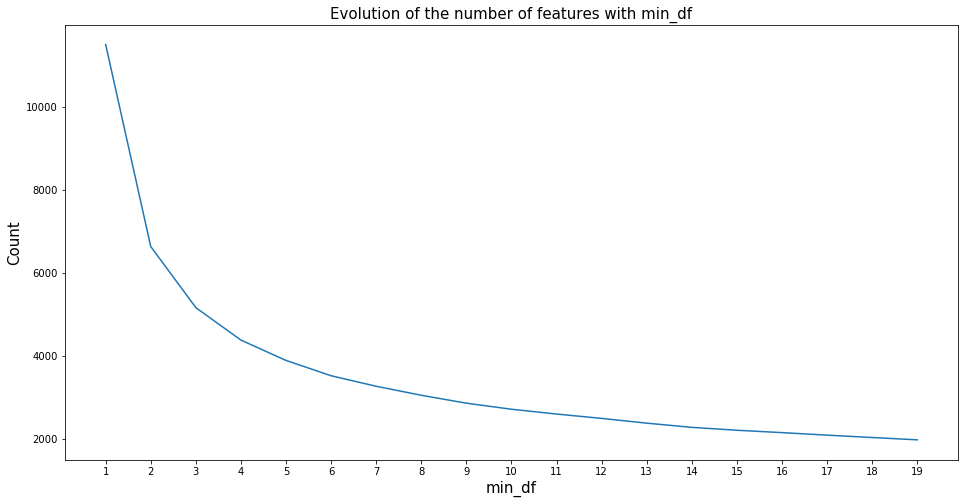

In [216]:
plt.figure(figsize=(16,8))
plt.plot(x,vect_size)
plt.title("Evolution of the number of features with min_df", fontsize=15)
plt.xlabel("min_df", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.xticks(x)
plt.show()

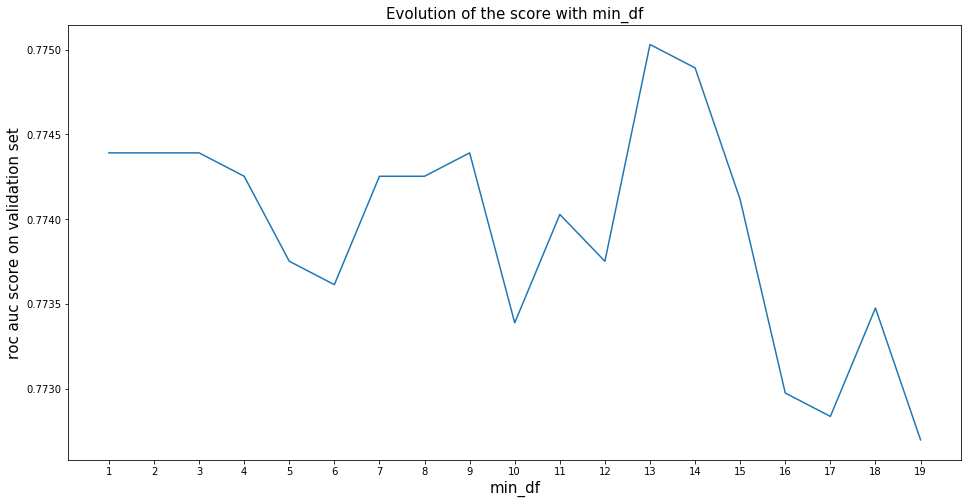

In [217]:
plt.figure(figsize=(16,8))
plt.plot(x,score)
plt.title("Evolution of the score with min_df", fontsize=15)
plt.xlabel("min_df", fontsize=15)
plt.ylabel("roc auc score on validation set", fontsize=15)
plt.xticks(x)
plt.show()

In [218]:
%%time
x = []
vect_size = []
score = []

for max_df in np.arange(1,len(txt_train),1000):
    vect = CountVectorizer(max_df=max_df)
    X_train = vect.fit_transform(txt_train)
    X_val = vect.transform(txt_val)
    clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
    x.append(max_df)
    vect_size.append(len(vect.vocabulary_))
    score.append(roc_auc_score(y_val, clf.predict(X_val)))

CPU times: user 3min 28s, sys: 4.5 s, total: 3min 32s
Wall time: 2min 5s


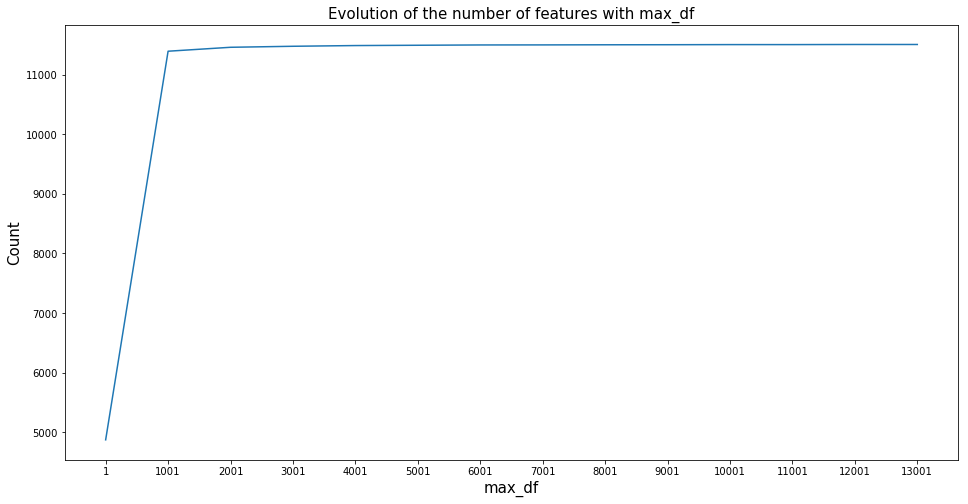

In [219]:
plt.figure(figsize=(16,8))
plt.plot(x,vect_size)
plt.title("Evolution of the number of features with max_df", fontsize=15)
plt.xlabel("max_df", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.xticks(x)
plt.show()

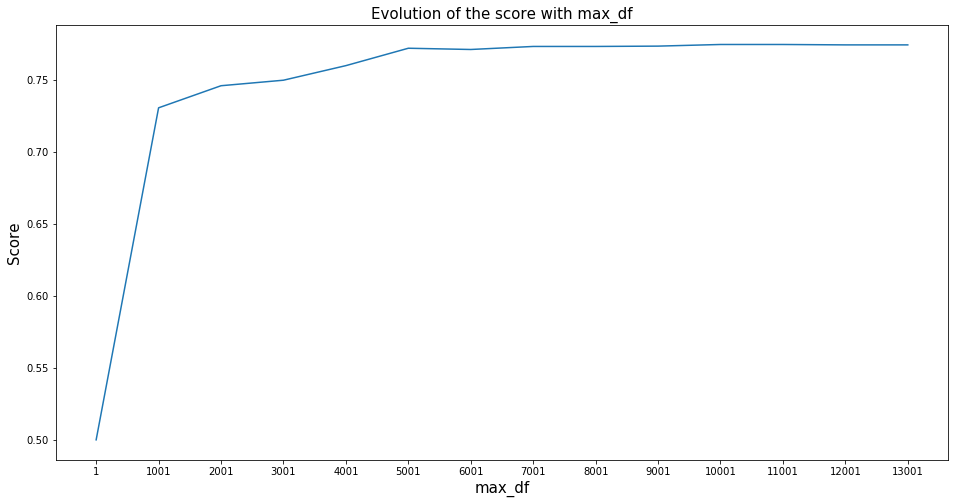

In [220]:
plt.figure(figsize=(16,8))
plt.plot(x,score)
plt.title("Evolution of the score with max_df", fontsize=15)
plt.xlabel("max_df", fontsize=15)
plt.ylabel("Score", fontsize=15)
plt.xticks(x)
plt.show()

As expected, the higher we set *min_df*, the fewer features we get. On the contrary, the higher we set *max_df* and the more features we obtain.
<br>
When the score is getting higher with *max_df*, it is not that clear with *min_df*. It seems to really negatively impact the score when set above 13, but before that threshold, the score goes up and down. We will try a set of *min_df* between 1 and 13 during grid-search.

### Best model Task 2

In [63]:
%%time
pipe = make_pipeline(CountVectorizer(), 
                     Normalizer(), 
                     LogisticRegression(), 
                     memory="cache_folder")
param_grid = {'countvectorizer__min_df': [1, 2, 3, 5, 7, 9, 11],
              'logisticregression__C': np.logspace(-4,4,10)}
grid = GridSearchCV(pipe, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    n_jobs=-1,
                    cv=5,
                    verbose=True)
grid.fit(txt_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  4.6min finished


CPU times: user 6.49 s, sys: 2.7 s, total: 9.19 s
Wall time: 4min 38s


In [64]:
print(roc_auc_score(y_val, grid.predict(txt_val)))

0.802422959437


### Test Set

After getting the best hyper-parameters (*min_df* and *C*) thanks to grid-search, we get our best model for Task 2. 

In [67]:
txt_train = df_train['Concat'].ravel()
y_train = df_train['Recommended'].ravel()
txt_test = df_test['Concat'].ravel()
y_test = df_test['Recommended'].ravel()

In [74]:
pipe_test = make_pipeline(CountVectorizer(), 
                          Normalizer(), 
                          LogisticRegression(C=grid.best_params_['logisticregression__C']), 
                          memory="cache_folder")
pipe_test.fit(txt_train, y_train)
y_pred = pipe_test.predict(txt_test)

In [75]:
print(roc_auc_score(y_test,y_pred))

0.81421816935


We obtain a slightly better AUC thanks to normalization.

# Task 3: n-grams

## 1)

In [76]:
df = df_train[['Concat', 'Recommended']]
txt = df['Concat'].ravel()
y = df['Recommended'].ravel()
txt_train, txt_val, y_train, y_val = train_test_split(txt, y, stratify=y)

In [77]:
%%time
pipe = make_pipeline(CountVectorizer(),
                     Normalizer(), 
                     LogisticRegression(),
                     memory="cache_folder")

param_grid = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 3),
                                               (2, 2), (3, 3)],
              'logisticregression__C': np.logspace(-4,4,10)
             }
grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    n_jobs=-1,
                    cv=5,
                    verbose=True)
grid.fit(txt_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 23.4min finished


CPU times: user 39.3 s, sys: 3.14 s, total: 42.4 s
Wall time: 23min 57s


Generating the unigrams, bigrams and trigrams provides the best performance.

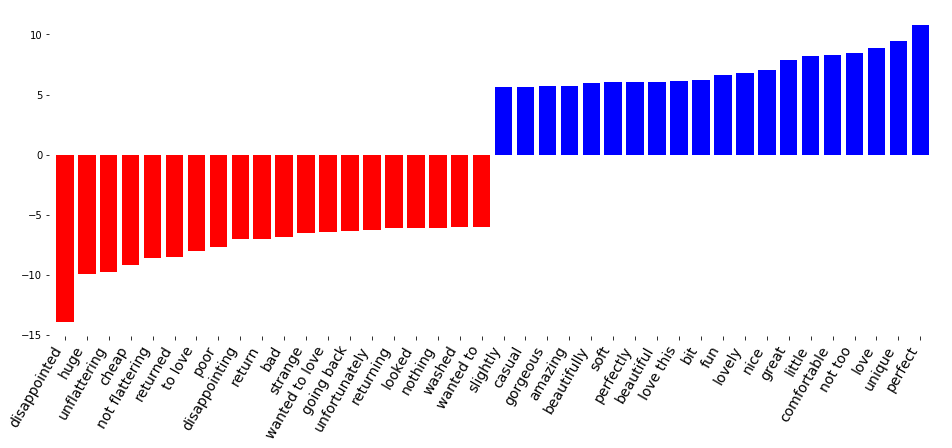

In [83]:
plt.figure(figsize=(16, 6))
plot_important_features(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), 
                        np.array(grid.best_estimator_.named_steps['countvectorizer'].get_feature_names()))
plt.show()

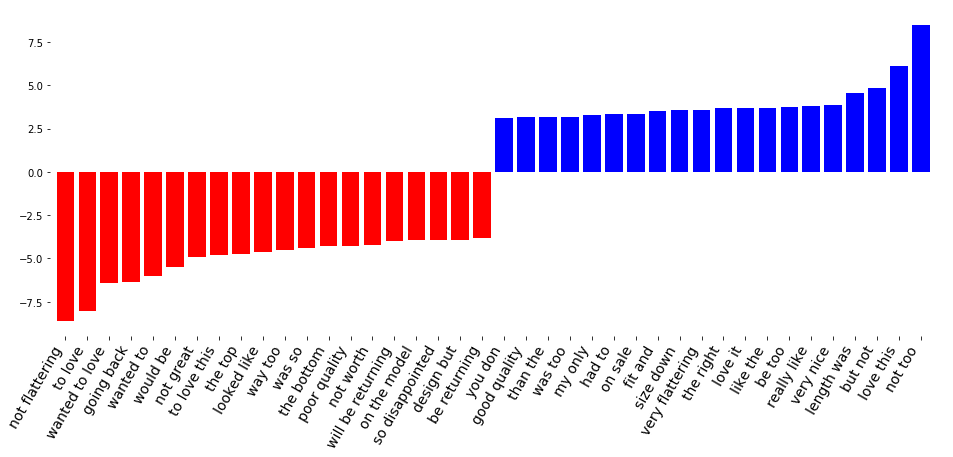

In [245]:
plt.figure(figsize=(16, 6))
plot_important_features(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(),
                        np.array(grid.best_estimator_.named_steps['countvectorizer'].get_feature_names()),
                        min_size=2)
plt.show()

Looking at best bigrams and trigrams, some express emphasis (**'very flattering'**, **'very nice'**, **'so disappointed'**), other negation (**'not flattering'**, **'not great'**, '**not worth'**) or concession (**'design but'**).
<br>
Surprisingly, we can find **'to love'**, **'to love this'** in the most negative features. Maybe they are all coming from *'wanted to love this'* that would show some regret.

In [88]:
print(roc_auc_score(y_val, grid.predict(txt_val)))

0.802989615888


## 2)

In [82]:
%%time
vect = CountVectorizer(ngram_range=(2, 3), analyzer="char")
X_train = vect.fit_transform(txt_train)
X_val = vect.transform(txt_val)
clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
score.append(roc_auc_score(y_val, clf.predict(X_val)))

CPU times: user 1min 29s, sys: 1.73 s, total: 1min 30s
Wall time: 50.6 s


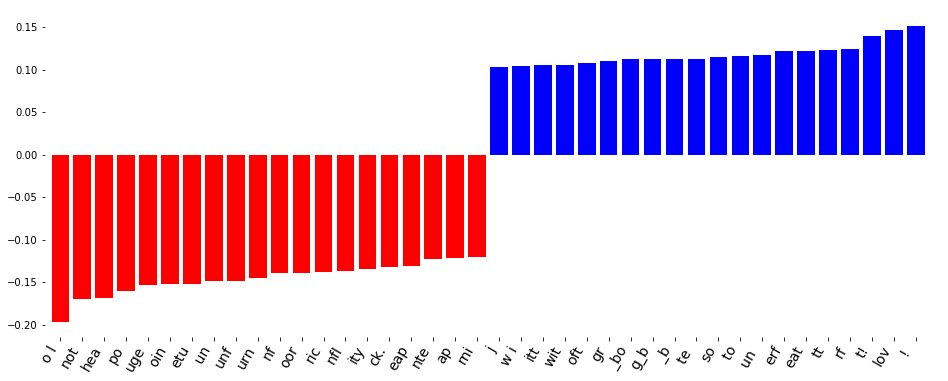

In [85]:
plt.figure(figsize=(16, 6))
plot_important_features(clf.coef_.ravel(), np.array(vect.get_feature_names()))
plt.show()

We learn that the punctuation seems to be important, **'!'** is the most positive feature. 

## 3)

In [96]:
%%time
x = []
vect_size = []
vect_uni_size = []
vect_bi_size = []
vect_tri_size = []
score = []

for min_df in np.arange(1,20,2):
    vect = CountVectorizer(ngram_range=(1,3),min_df=min_df)
    X_train = vect.fit_transform(txt_train)
    X_val = vect.transform(txt_val)
    clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
    x.append(min_df)
    vect_size.append(len(vect.get_feature_names()))
    mask_uni = np.array([len(i.split(" ")) == 1 for i in vect.get_feature_names()])
    mask_bi = np.array([len(i.split(" ")) == 2 for i in vect.get_feature_names()])
    mask_tri = np.array([len(i.split(" ")) == 3 for i in vect.get_feature_names()])
    vect_uni_size.append(len(np.array(vect.get_feature_names())[mask_uni]))
    vect_bi_size.append(len(np.array(vect.get_feature_names())[mask_bi]))
    vect_tri_size.append(len(np.array(vect.get_feature_names())[mask_tri]))
    score.append(roc_auc_score(y_val, clf.predict(X_val)))

CPU times: user 13min 20s, sys: 24 s, total: 13min 44s
Wall time: 7min 56s


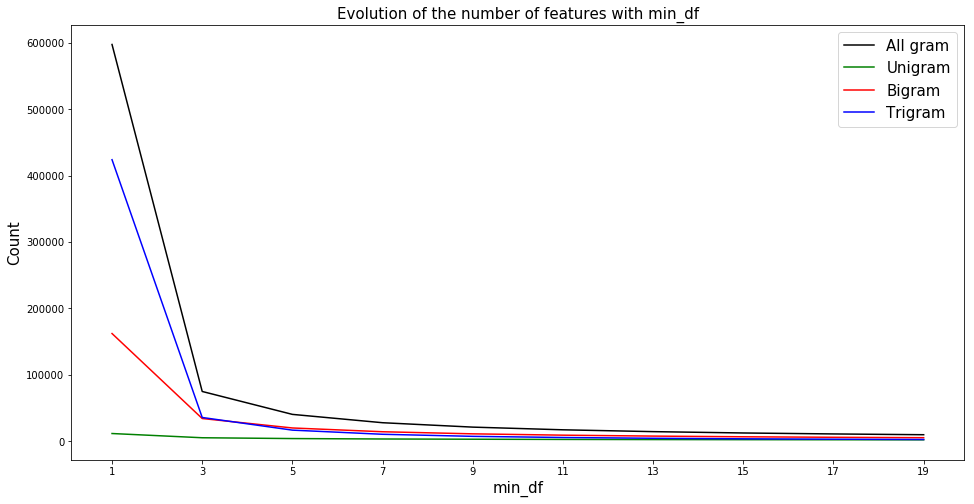

In [124]:
plt.figure(figsize=(16,8))
p1 = plt.plot(x, vect_size, color='black')
p2 = plt.plot(x, vect_uni_size, color='green')
p3 = plt.plot(x, vect_bi_size, color='red')
p4 = plt.plot(x, vect_tri_size, color='blue')
plt.title("Evolution of the number of features with min_df", fontsize=15)
plt.xlabel('min_df', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(x)
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('All gram', 'Unigram', 'Bigram', 'Trigram'), fontsize=15)
plt.show()

Increasing *min_df* has a greater impact on higher level n-grams.

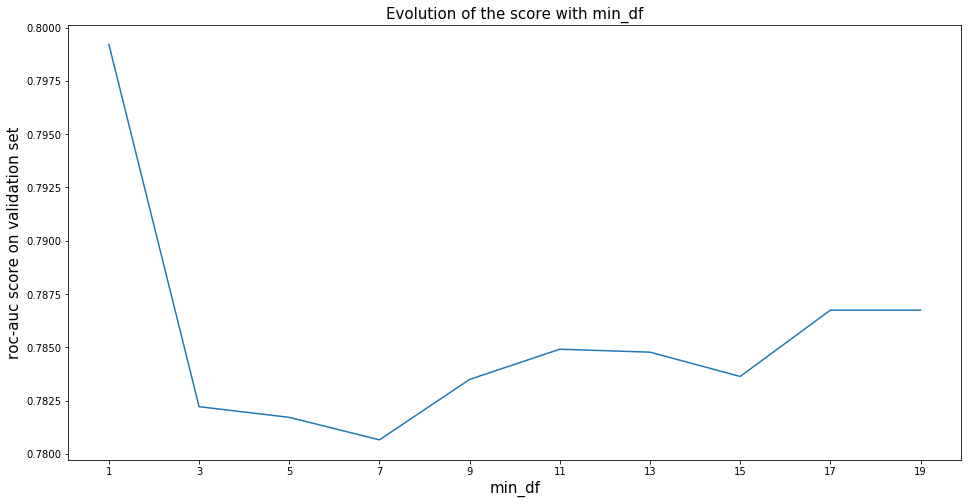

In [125]:
plt.figure(figsize=(16,8))
plt.plot(x,score)
plt.title("Evolution of the score with min_df", fontsize=15)
plt.xlabel('min_df', fontsize=15)
plt.ylabel('roc-auc score on validation set', fontsize=15)
plt.xticks(x)
plt.show()

Increasing *min_df* has a negative impact on the AUC score.

In [100]:
vect = CountVectorizer(ngram_range=(1,3))
X_train = vect.fit_transform(txt_train)
X_val = vect.transform(txt_val)
clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
mask_uni = np.array([len(i.split(" ")) == 1 for i in vect.get_feature_names()])
mask_bi = np.array([len(i.split(" ")) == 2 for i in vect.get_feature_names()])
mask_tri = np.array([len(i.split(" ")) == 3 for i in vect.get_feature_names()])
print('All words:', len(vect.get_feature_names()))
print('Unigram:', len(np.array(vect.get_feature_names())[mask_uni]))
print('Bigram:', len(np.array(vect.get_feature_names())[mask_bi]))
print('Trigram:', len(np.array(vect.get_feature_names())[mask_tri]))
print('Score:', roc_auc_score(y_val, clf.predict(X_val)))

All words: 597312
Unigram: 11477
Bigram: 162031
Trigram: 423804
Score: 0.799204138958


In [101]:
vect = CountVectorizer(ngram_range=(1,3),stop_words='english')
X_train = vect.fit_transform(txt_train)
X_val = vect.transform(txt_val)
clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train, y_train)
mask_uni = np.array([len(i.split(" ")) == 1 for i in vect.get_feature_names()])
mask_bi = np.array([len(i.split(" ")) == 2 for i in vect.get_feature_names()])
mask_tri = np.array([len(i.split(" ")) == 3 for i in vect.get_feature_names()])
print('All words:', len(vect.get_feature_names()))
print('Unigram:', len(np.array(vect.get_feature_names())[mask_uni]))
print('Bigram:', len(np.array(vect.get_feature_names())[mask_bi]))
print('Trigram:', len(np.array(vect.get_feature_names())[mask_tri]))
print('Score:', roc_auc_score(y_val, clf.predict(X_val)))

All words: 477720
Unigram: 11198
Bigram: 169297
Trigram: 297225
Score: 0.774180872503


The use of english stop-words slightly lower the score. It increases the number of bigrams but decreases the number of unigrams, trigrams and the overall number of features.

### Test Set

At the end of Task 3, our best model considers unigrams, bigrams and trigrams, it uses CountVectorizer and Normalizer.

In [102]:
txt_train = df_train['Concat'].ravel()
y_train = df_train['Recommended'].ravel()
txt_test = df_test['Concat'].ravel()
y_test = df_test['Recommended'].ravel()

In [105]:
pipe_test = make_pipeline(CountVectorizer(ngram_range=grid.best_params_['countvectorizer__ngram_range']),
                     Normalizer(), 
                     LogisticRegression(C=grid.best_params_['logisticregression__C']),
                     memory="cache_folder")
pipe_test.fit(txt_train, y_train)
print(roc_auc_score(y_test, pipe_test.predict(txt_test)))

0.819629209671


The AUC score is increasing again thanks to n-grams.

# Task 4: Model Tuning 

We build a linear model using the best 1000 positive features and best 1000 negative features from our last model in Task 3. 

In [180]:
df = df_train[['Concat', 'Recommended']]
txt = df['Concat'].ravel()
y = df['Recommended'].ravel()
txt_train, txt_val, y_train, y_val = train_test_split(txt, y, stratify=y)

In [181]:
pipe_tune = make_pipeline(CountVectorizer(ngram_range=grid.best_params_['countvectorizer__ngram_range']),
                          Normalizer(), 
                          LogisticRegression(C=grid.best_params_['logisticregression__C']),
                          memory="cache_folder")
pipe_tune.fit(txt_train, y_train)
inds = np.argsort(pipe_tune.named_steps['logisticregression'].coef_[0])
low = inds[:1000]
high = inds[-1000:]
important = np.hstack([low, high])
vocab = np.array(pipe_tune.named_steps['countvectorizer'].get_feature_names())[important]

In [182]:
print(roc_auc_score(y_val, pipe_tune.predict(txt_val)))

0.822796112419


Grid-search on different model using L1 or L2 penalty:

In [183]:
%%time
pipe_task4 = make_pipeline(CountVectorizer(ngram_range=(1,3), vocabulary = vocab),
                              Normalizer(), 
                              SGDClassifier(),
                              memory="cache_folder")
param_grid = {'sgdclassifier__penalty': ['l1', 'l2'],
              'sgdclassifier__alpha': np.logspace(-4,4,10)}
grid_task4 = GridSearchCV(pipe_task4,
                          param_grid=param_grid,
                          scoring='roc_auc',
                          n_jobs=-1,
                          cv=5,
                          verbose=True)
grid_task4.fit(txt_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/Louis/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


CPU times: user 4.3 s, sys: 1.04 s, total: 5.34 s
Wall time: 2min 15s


In [184]:
grid_task4.best_params_

{'sgdclassifier__alpha': 0.0001, 'sgdclassifier__penalty': 'l2'}

### Test Set

We can evaluate our final model on the test set.

In [185]:
pipe_test = make_pipeline(CountVectorizer(ngram_range=(1,3), vocabulary = vocab),
                              Normalizer(), 
                              SGDClassifier(alpha=grid_task4.best_params_['sgdclassifier__alpha'],
                                            penalty = grid_task4.best_params_['sgdclassifier__penalty']),
                              memory="cache_folder")

/Users/Louis/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [186]:
txt_train = df_train['Concat'].ravel()
y_train = df_train['Recommended'].ravel()

In [187]:
pipe_test.fit(txt_train, y_train)
print(roc_auc_score(y_test, pipe_test.predict(txt_test)))

0.829815351364


The AUC score again slightly increased.

Stemming the features could be a good idea, including the punctuation also.
<br>
Trying polynomial combinations of the best features could also be worth trying out.
<br>
Doing Latent Semantic Analysis (LSA) could also be interesting, in order to reduce the dimensionality of the problem and find components that capture sentiment.